**Importing libraries and loading the data**

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn  as sns
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression, Lasso, Ridge 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import math
import xgboost
import pickle

In [167]:
#from google.colab import drive
#drive.mount('/content/drive')

In [168]:
#loading all needed datasets from kaggle
calendar = pd.read_csv('../data/raw/calendar.csv')
sell_prices = pd.read_csv('../data/raw/sell_prices.csv')
sales_validation = pd.read_csv('../data/raw/sales_train_validation.csv')

## Exploratory Data Analysis

In [169]:
sales_validation.info

<bound method DataFrame.info of                                   id        item_id    dept_id   cat_id  \
0      HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES   
1      HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES   
2      HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES   
3      HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES   
4      HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES   
...                              ...            ...        ...      ...   
30485    FOODS_3_823_WI_3_validation    FOODS_3_823    FOODS_3    FOODS   
30486    FOODS_3_824_WI_3_validation    FOODS_3_824    FOODS_3    FOODS   
30487    FOODS_3_825_WI_3_validation    FOODS_3_825    FOODS_3    FOODS   
30488    FOODS_3_826_WI_3_validation    FOODS_3_826    FOODS_3    FOODS   
30489    FOODS_3_827_WI_3_validation    FOODS_3_827    FOODS_3    FOODS   

      store_id state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d

In [170]:
unique_items = len(sales_validation['item_id'].unique())
unique_item_categories = len(sales_validation['cat_id'].unique())
unique_departments = len(sales_validation['dept_id'].unique())
unique_stores = len(sales_validation['store_id'].unique())
unique_states = len(sales_validation['state_id'].unique())

print(f'Number of \n unique states: {unique_states} \n unique stores: {unique_stores} \n unique departments: {unique_departments} \n unique item categories: {unique_item_categories} \n unique items: {unique_items}')

Number of 
 unique states: 3 
 unique stores: 10 
 unique departments: 7 
 unique item categories: 3 
 unique items: 3049


In [171]:
for col in [sales_validation['cat_id'],sales_validation['dept_id'],sales_validation['store_id'],sales_validation['state_id']]:
  print (col.unique())

['HOBBIES' 'HOUSEHOLD' 'FOODS']
['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['CA' 'TX' 'WI']


In [172]:
# Inspection of data types
print("Data types in sales_validation are: \n", sales_validation.dtypes.value_counts())

Data types in sales_validation are: 
 int64     1913
object       6
dtype: int64


In [173]:
duplicated_rows_count = sales_validation.duplicated().sum()
print(f'The number of duplicated rows is {duplicated_rows_count}.')

The number of duplicated rows is 0.


In [174]:
# Checking for null values column-wise
sales_validation.isna().sum(axis=1).sort_values(ascending=False)

0        0
20322    0
20334    0
20333    0
20332    0
        ..
10159    0
10158    0
10157    0
10156    0
30489    0
Length: 30490, dtype: int64

In [175]:
# Checking for null values row-wise
sales_validation.isna().sum().sort_values(ascending=False)

id        0
d_1270    0
d_1282    0
d_1281    0
d_1280    0
         ..
d_630     0
d_629     0
d_628     0
d_627     0
d_1913    0
Length: 1919, dtype: int64

In [176]:
calendar.info

<bound method DataFrame.info of             date  wm_yr_wk    weekday  wday  month  year       d  \
0     2011-01-29     11101   Saturday     1      1  2011     d_1   
1     2011-01-30     11101     Sunday     2      1  2011     d_2   
2     2011-01-31     11101     Monday     3      1  2011     d_3   
3     2011-02-01     11101    Tuesday     4      2  2011     d_4   
4     2011-02-02     11101  Wednesday     5      2  2011     d_5   
...          ...       ...        ...   ...    ...   ...     ...   
1964  2016-06-15     11620  Wednesday     5      6  2016  d_1965   
1965  2016-06-16     11620   Thursday     6      6  2016  d_1966   
1966  2016-06-17     11620     Friday     7      6  2016  d_1967   
1967  2016-06-18     11621   Saturday     1      6  2016  d_1968   
1968  2016-06-19     11621     Sunday     2      6  2016  d_1969   

      event_name_1 event_type_1  event_name_2 event_type_2  snap_CA  snap_TX  \
0              NaN          NaN           NaN          NaN        0    

In [177]:
unique_year = len(calendar['year'].unique())
unique_events = len(calendar['event_name_1'].unique()) + len(calendar['event_name_2'].unique())
unique_states = len(calendar['event_type_1'].unique())
print(f'Number of \n unique years: {unique_year} \n unique events: {unique_events} \n unique types of events: {unique_states}')

Number of 
 unique years: 6 
 unique events: 36 
 unique types of events: 5


In [178]:
for col in [calendar['year'],calendar['event_name_1'],calendar['event_type_1'],calendar['event_name_2']]:
  print (col.unique())

[2011 2012 2013 2014 2015 2016]
[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
[nan 'Sporting' 'Cultural' 'National' 'Religious']
[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


In [179]:
# Inspection of data types
print("Data types in calendar are: \n", calendar.dtypes.value_counts())

Data types in calendar are: 
 object    7
int64     7
dtype: int64


In [180]:
calendar.dtypes.head(14)

date            object
wm_yr_wk         int64
weekday         object
wday             int64
month            int64
year             int64
d               object
event_name_1    object
event_type_1    object
event_name_2    object
event_type_2    object
snap_CA          int64
snap_TX          int64
snap_WI          int64
dtype: object

In [181]:
duplicated_rows_count = calendar.duplicated().sum()
print(f'The number of duplicated rows is {duplicated_rows_count}.')

The number of duplicated rows is 0.


In [182]:
#Checking for null values column-wise
calendar.isna().sum(axis=1).sort_values(ascending=False)

0       4
1281    4
1293    4
1292    4
1291    4
       ..
85      0
1233    0
827     0
1177    0
1968    0
Length: 1969, dtype: int64

In [183]:
# Checking for null values row-wise
calendar.isna().sum().sort_values(ascending=False)

event_name_2    1964
event_type_2    1964
event_name_1    1807
event_type_1    1807
date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
d                  0
snap_CA            0
snap_TX            0
snap_WI            0
dtype: int64

In [184]:
sell_prices.info

<bound method DataFrame.info of         store_id        item_id  wm_yr_wk  sell_price
0           CA_1  HOBBIES_1_001     11325        9.58
1           CA_1  HOBBIES_1_001     11326        9.58
2           CA_1  HOBBIES_1_001     11327        8.26
3           CA_1  HOBBIES_1_001     11328        8.26
4           CA_1  HOBBIES_1_001     11329        8.26
...          ...            ...       ...         ...
6841116     WI_3    FOODS_3_827     11617        1.00
6841117     WI_3    FOODS_3_827     11618        1.00
6841118     WI_3    FOODS_3_827     11619        1.00
6841119     WI_3    FOODS_3_827     11620        1.00
6841120     WI_3    FOODS_3_827     11621        1.00

[6841121 rows x 4 columns]>

In [185]:
unique_store_sell = len(sell_prices['store_id'].unique())
unique_item_sell = len(sell_prices['item_id'].unique())
unique_id_week = len(sell_prices['wm_yr_wk'].unique())
unique_sell_price = len(sell_prices['sell_price'].unique())
print(f'Number of \n unique stores: {unique_store_sell} \n unique item ids: {unique_item_sell} \n unique id_weeks: {unique_id_week} \n unique sell_prices {unique_sell_price}')

Number of 
 unique stores: 10 
 unique item ids: 3049 
 unique id_weeks: 282 
 unique sell_prices 1048


In [186]:
for col in [sell_prices['store_id'],sell_prices['item_id'],sell_prices['wm_yr_wk'],sell_prices['sell_price']]:
  print (col.unique())

['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
[11325 11326 11327 11328 11329 11330 11331 11332 11333 11334 11335 11336
 11337 11338 11339 11340 11341 11342 11343 11344 11345 11346 11347 11348
 11349 11350 11351 11352 11353 11401 11402 11403 11404 11405 11406 11407
 11408 11409 11410 11411 11412 11413 11414 11415 11416 11417 11418 11419
 11420 11421 11422 11423 11424 11425 11426 11427 11428 11429 11430 11431
 11432 11433 11434 11435 11436 11437 11438 11439 11440 11441 11442 11443
 11444 11445 11446 11447 11448 11449 11450 11451 11452 11501 11502 11503
 11504 11505 11506 11507 11508 11509 11510 11511 11512 11513 11514 11515
 11516 11517 11518 11519 11520 11521 11522 11523 11524 11525 11526 11527
 11528 11529 11530 11531 11532 11533 11534 11535 11536 11537 11538 11539
 11540 11541 11542 11543 11544 11545 11546 11547 11548 11549 11550 11551
 11552 11601 11602 11603 116

In [187]:
# Inspection of data types
print("Data types in sell_prices are: \n", sell_prices.dtypes.value_counts())

Data types in sell_prices are: 
 object     2
float64    1
int64      1
dtype: int64


In [188]:
sell_prices.dtypes.head(14)

store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object

In [189]:
duplicated_rows_count = sell_prices.duplicated().sum()
print(f'The number of duplicated rows is {duplicated_rows_count}.')

The number of duplicated rows is 0.


In [190]:
#Checking for null values column-wise
sell_prices.isna().sum(axis=1).sort_values(ascending=False)

0          0
4560678    0
4560754    0
4560753    0
4560752    0
          ..
2280371    0
2280370    0
2280369    0
2280368    0
6841120    0
Length: 6841121, dtype: int64

In [191]:
# Checking for null values row-wise
sell_prices.isna().sum().sort_values(ascending=False)

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64

In [192]:
item = pd.read_csv('../data/raw/item_id_sample.csv') #asi bude treba nahravat opakovane
print(item.head())

   Unnamed: 0        item_id    dept_id
0          48  HOBBIES_1_049  HOBBIES_1
1         381  HOBBIES_1_390  HOBBIES_1
2         150  HOBBIES_1_155  HOBBIES_1
3         287  HOBBIES_1_296  HOBBIES_1
4         415  HOBBIES_1_424  HOBBIES_1


In [193]:
# prints all unique values in all columns
for column in item.columns:
    unique_vals = item[column].unique()
    print(f"Unique values in {column}:")
    print(unique_vals)

    # item dataset is probably some sort of list of item ids which we should include in our analysis

Unique values in Unnamed: 0:
[  48  381  150  287  415   56  195  187  154  397  418  443  522  546
  444  468  551  426  491  515  704  786 1082 1038  771  662  887  818
  865  815 1241 1529 1562 1484 1229 1356 1521 1327 1155 1295 1627 1714
 1676 1777 1782 1681 1783 1621 1745 1659 2149 2192 2002 2043 2145 1932
 2153 2212 2082 1944 2403 2749 2883 2951 2979 2538 2629 2511 2442 2639]
Unique values in item_id:
['HOBBIES_1_049' 'HOBBIES_1_390' 'HOBBIES_1_155' 'HOBBIES_1_296'
 'HOBBIES_1_424' 'HOBBIES_1_057' 'HOBBIES_1_202' 'HOBBIES_1_193'
 'HOBBIES_1_159' 'HOBBIES_1_406' 'HOBBIES_2_003' 'HOBBIES_2_028'
 'HOBBIES_2_107' 'HOBBIES_2_131' 'HOBBIES_2_029' 'HOBBIES_2_053'
 'HOBBIES_2_136' 'HOBBIES_2_011' 'HOBBIES_2_076' 'HOBBIES_2_100'
 'HOUSEHOLD_1_144' 'HOUSEHOLD_1_226' 'HOUSEHOLD_1_527' 'HOUSEHOLD_1_483'
 'HOUSEHOLD_1_211' 'HOUSEHOLD_1_101' 'HOUSEHOLD_1_329' 'HOUSEHOLD_1_259'
 'HOUSEHOLD_1_307' 'HOUSEHOLD_1_256' 'HOUSEHOLD_2_145' 'HOUSEHOLD_2_434'
 'HOUSEHOLD_2_467' 'HOUSEHOLD_2_389' 'HOUSEHO

In [194]:
print("Data types in item_ids are: \n", item.dtypes)

Data types in item_ids are: 
 Unnamed: 0     int64
item_id       object
dept_id       object
dtype: object


In [195]:
# lets find out what combination of item id and dept id are missing from item!
unique_item_ids_not_in_item = sales_validation.loc[~sales_validation['item_id'].isin(item['item_id']), 'item_id'].unique()
unique_dept_ids_not_in_item = sales_validation.loc[~sales_validation['dept_id'].isin(item['dept_id']), 'dept_id'].unique()
print("Unique item_ids in 'sales_validation' that are NOT in 'item':", unique_item_ids_not_in_item)
print("Unique dept_ids in 'sales_validation' that are NOT in 'item':", unique_dept_ids_not_in_item)


Unique item_ids in 'sales_validation' that are NOT in 'item': ['HOBBIES_1_001' 'HOBBIES_1_002' 'HOBBIES_1_003' ... 'FOODS_3_825'
 'FOODS_3_826' 'FOODS_3_827']
Unique dept_ids in 'sales_validation' that are NOT in 'item': []


In [196]:
# by using merge we can as join the two datasets together as filter out all the useless combinations
filtered_df = pd.merge(sales_validation, item[['item_id', 'dept_id']],
                                     how='inner',
                                     on=['item_id', 'dept_id'])

# diagnostic stuff
print("Number of rows before filtering:", len(sales_validation))
print("Number of rows after filtering:", len(filtered_df))

print(filtered_df.head())


Number of rows before filtering: 30490
Number of rows after filtering: 700
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       0       0       1       0       1   
1       CA    0    0    0    0  ...       0       1       0       0       0   
2       CA    0    0    0    0  ...       0       2       0       1       2   
3       CA    0    0    0    0  ...       2       0       0       1       0   
4       TX    0    0    0    0  ...       0      

In [197]:
print(filtered_df.columns)
print(filtered_df.shape)

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd_1',
       'd_2', 'd_3', 'd_4',
       ...
       'd_1904', 'd_1905', 'd_1906', 'd_1907', 'd_1908', 'd_1909', 'd_1910',
       'd_1911', 'd_1912', 'd_1913'],
      dtype='object', length=1919)
(700, 1919)


In [198]:
print(calendar.head())
print(len(calendar))

         date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1  
1969


In [199]:
melted_filtered_df = pd.melt(filtered_df,
                             id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                             var_name='d',
                             value_name='sales')
print(melted_filtered_df.head())
print(melted_filtered_df.d.unique()) # error check
print(melted_filtered_df.sales.unique())
print(len(melted_filtered_df))

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id    d  sales  
0       CA  d_1      0  
1       CA  d_1      0  
2       CA  d_1      0  
3       CA  d_1      0  
4       TX  d_1      0  
['d_1' 'd_2' 'd_3' ... 'd_1911' 'd_1912' 'd_1913']
[ 0  2  5  1  3 16  4 17  7  6 10  9 12 13  8 18 11 14 19 43 23 24 20 15
 41 22 37 21 27 36 61 30 25 34 31 28 26 35 39 84 33 29 48]
1339100


In [200]:
merged_df = pd.merge(melted_filtered_df, calendar, how='inner', on='d')
print(merged_df.head())
print(merged_df.columns) # see we have four different columns connected into events.let's make them 2!
print(len(merged_df))

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id    d  sales        date  wm_yr_wk  ... wday  month  year  \
0       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
1       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
2       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
3       CA  d_1      0  2011-01-29     11101  ...    1      1  2011   
4       TX  d_1      0  2011-01-29     11101  ...    1      1  2011   

   event_name_1 event_type_1 event_name_2 event_type_2 snap_CA  snap_TX  \
0           NaN  

In [201]:
print(merged_df.event_type_1.unique())
print(merged_df.event_type_2.unique())
print(merged_df.event_name_1.unique())
print(merged_df.event_name_2.unique())

[nan 'Sporting' 'Cultural' 'National' 'Religious']
[nan 'Cultural' 'Religious']
[nan 'SuperBowl' 'ValentinesDay' 'PresidentsDay' 'LentStart' 'LentWeek2'
 'StPatricksDay' 'Purim End' 'OrthodoxEaster' 'Pesach End' 'Cinco De Mayo'
 "Mother's day" 'MemorialDay' 'NBAFinalsStart' 'NBAFinalsEnd'
 "Father's day" 'IndependenceDay' 'Ramadan starts' 'Eid al-Fitr'
 'LaborDay' 'ColumbusDay' 'Halloween' 'EidAlAdha' 'VeteransDay'
 'Thanksgiving' 'Christmas' 'Chanukah End' 'NewYear' 'OrthodoxChristmas'
 'MartinLutherKingDay' 'Easter']
[nan 'Easter' 'Cinco De Mayo' 'OrthodoxEaster' "Father's day"]


In [202]:
# melt (aka make them long-form rather than wide-form)
df_event_name_melted = pd.melt(merged_df,
                               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date'],
                               value_vars=['event_name_1', 'event_name_2'],
                               var_name='event_name_type',
                               value_name='event_name')
df_event_type_melted = pd.melt(merged_df,
                               id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date'],
                               value_vars=['event_type_1', 'event_type_2'],
                               var_name='event_type_type',
                               value_name='event_type')
df_event_name_melted.drop('event_name_type', axis=1, inplace=True)
df_event_type_melted.drop('event_type_type', axis=1, inplace=True)

sort_columns = ['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd', 'sales', 'date']

df_event_name_melted.sort_values(by=sort_columns, inplace=True)
df_event_type_melted.sort_values(by=sort_columns, inplace=True)

cols_event_name = ['event_name']
cols_event_type = ['event_type']

final_df = pd.concat([df_event_name_melted[sort_columns],
                      merged_df[['wm_yr_wk', 'weekday', 'wday', 'month', 'year', 'snap_CA', 'snap_TX', 'snap_WI']],
                      df_event_name_melted[cols_event_name],
                      df_event_type_melted[cols_event_type]], axis=1)
final_df.dropna(subset=['weekday', 'month'], inplace=True)


In [203]:
print(final_df.head())
print(final_df.columns)
print(final_df.event_type.unique()) #error check
print(final_df.event_name.unique()) #error check

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id    d  sales        date  wm_yr_wk   weekday  wday  month    year  \
0       CA  d_1      0  2011-01-29   11101.0  Saturday   1.0    1.0  2011.0   
1       CA  d_1      0  2011-01-29   11101.0  Saturday   1.0    1.0  2011.0   
2       CA  d_1      0  2011-01-29   11101.0  Saturday   1.0    1.0  2011.0   
3       CA  d_1      0  2011-01-29   11101.0  Saturday   1.0    1.0  2011.0   
4       TX  d_1      0  2011-01-29   11101.0  Saturday   1.0    1.0  2011.0   

   snap_CA  snap_TX  snap_WI event_name even

In [204]:
nan_count = final_df.isna().sum()

# sum of nan values in all columns
print("Sum of NaN values in each column:")
print(nan_count)
print(f"total rows: {len(final_df)}")

Sum of NaN values in each column:
id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
d                   0
sales               0
date                0
wm_yr_wk            0
weekday             0
wday                0
month               0
year                0
snap_CA             0
snap_TX             0
snap_WI             0
event_name    1231300
event_type    1231300
dtype: int64
total rows: 1339100


In [205]:
# sell prices dataframe is still missing, so here we go!
print(sell_prices.head())
print(sell_prices.dtypes)

  store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26
store_id       object
item_id        object
wm_yr_wk        int64
sell_price    float64
dtype: object


In [206]:
#print(final_df.head()) # the wm_yr_wk column is float and has decimal places, in comparison to sell_prices wm_yr_wk col which does not have decimal places
#print(final_df.dtypes)
final_df['wm_yr_wk'] = final_df['wm_yr_wk'].astype(int)
final_df['wm_yr_wk'] = final_df['wm_yr_wk'].astype('object')
print(final_df.head())

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id    d  sales        date wm_yr_wk   weekday  wday  month    year  \
0       CA  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   
1       CA  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   
2       CA  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   
3       CA  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   
4       TX  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   

   snap_CA  snap_TX  snap_WI event_name event_type

In [207]:
print(sell_prices.isna().sum())

store_id      0
item_id       0
wm_yr_wk      0
sell_price    0
dtype: int64


In [208]:
final_df = pd.merge(final_df,
                    sell_prices[['store_id', 'item_id', 'wm_yr_wk', 'sell_price']],
                    on=['store_id', 'item_id', 'wm_yr_wk'],
                    how='left')

In [209]:
print(final_df.head())

                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_049_CA_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_049_CA_2_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_2   
2  HOBBIES_1_049_CA_3_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_3   
3  HOBBIES_1_049_CA_4_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     CA_4   
4  HOBBIES_1_049_TX_1_validation  HOBBIES_1_049  HOBBIES_1  HOBBIES     TX_1   

  state_id    d  sales        date wm_yr_wk   weekday  wday  month    year  \
0       CA  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   
1       CA  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   
2       CA  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   
3       CA  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   
4       TX  d_1      0  2011-01-29    11101  Saturday   1.0    1.0  2011.0   

   snap_CA  snap_TX  snap_WI event_name event_type

In [210]:
final_df = final_df.drop_duplicates()
print(final_df.isna().sum())

print(final_df.notna().sum())
print(final_df.shape)
print(final_df.date.max())

id                  0
item_id             0
dept_id             0
cat_id              0
store_id            0
state_id            0
d                   0
sales               0
date                0
wm_yr_wk            0
weekday             0
wday                0
month               0
year                0
snap_CA             0
snap_TX             0
snap_WI             0
event_name    1231300
event_type    1231300
sell_price     202188
dtype: int64
id            1339100
item_id       1339100
dept_id       1339100
cat_id        1339100
store_id      1339100
state_id      1339100
d             1339100
sales         1339100
date          1339100
wm_yr_wk      1339100
weekday       1339100
wday          1339100
month         1339100
year          1339100
snap_CA       1339100
snap_TX       1339100
snap_WI       1339100
event_name     107800
event_type     107800
sell_price    1136912
dtype: int64
(1339100, 20)
2016-04-24


In [211]:
filtered_df = final_df[final_df['sell_price'].isna()]
filtered_df.drop_duplicates()
print(filtered_df.isna().sum())
filtered_df.date.max()


id                 0
item_id            0
dept_id            0
cat_id             0
store_id           0
state_id           0
d                  0
sales              0
date               0
wm_yr_wk           0
weekday            0
wday               0
month              0
year               0
snap_CA            0
snap_TX            0
snap_WI            0
event_name    185439
event_type    185439
sell_price    202188
dtype: int64


'2015-12-25'

In [212]:
unique_item_ids_not_in_item = filtered_df.loc[~filtered_df['item_id'].isin(item['item_id']), 'item_id'].unique()
unique_dept_ids_not_in_item = filtered_df.loc[~filtered_df['dept_id'].isin(item['dept_id']), 'dept_id'].unique()
print("Unique item_ids in 'sales_validation' that are NOT in 'item':", unique_item_ids_not_in_item)
print("Unique dept_ids in 'sales_validation' that are NOT in 'item':", unique_dept_ids_not_in_item)


Unique item_ids in 'sales_validation' that are NOT in 'item': []
Unique dept_ids in 'sales_validation' that are NOT in 'item': []


In [213]:
#change column d type from string to inteager
final_df.d = final_df.d.str.replace("d_","")
final_df.d = final_df.d.astype(int)
print(final_df.d)

0             1
1             1
2             1
3             1
4             1
           ... 
1339095    1913
1339096    1913
1339097    1913
1339098    1913
1339099    1913
Name: d, Length: 1339100, dtype: int32


In [214]:
final_df['date'] = pd.to_datetime(final_df['date']) 
final_df["month"] = final_df['date'].dt.strftime('%B')

In [215]:
#new column turnover
final_df["turnover"] = final_df.sales * final_df.sell_price
final_df = final_df.dropna(subset=["turnover"])
print(f"Count of na values in column turnover: {final_df.turnover.isna().sum()}")

Count of na values in column turnover: 0


In [216]:
#Drop rows where date is higher than 1.2.2016
final_df = final_df[final_df.date <= "2016-02-01"]

#Length of dataframe after drop
len(final_df)

1078812

In [217]:
final_df.columns

Index(['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'd',
       'sales', 'date', 'wm_yr_wk', 'weekday', 'wday', 'month', 'year',
       'snap_CA', 'snap_TX', 'snap_WI', 'event_name', 'event_type',
       'sell_price', 'turnover'],
      dtype='object')

In [218]:
#Droping columns
final_df = final_df.drop(["snap_TX", "snap_CA", "snap_WI", "event_name", "wday"],axis =1)

In [219]:
#Rolling windows and lagged variables

new_columns = ["turnover_d_1", "turnover_d_2", "turnover_d_3",
               "turnover_month_avg", "turnover_month_max", "turnover_month_min",
               "turnover_week_avg", "turnover_week_max", "turnover_week_min"]

final_df[new_columns[0]] = final_df.groupby('id')['turnover'].shift(1)
final_df[new_columns[1]] = final_df.groupby('id')['turnover'].shift(2)
final_df[new_columns[2]] = final_df.groupby('id')['turnover'].shift(3)
final_df[new_columns[3]] = final_df.groupby('id')['turnover_d_1'].transform(lambda x: x.rolling(30).mean())
final_df[new_columns[4]] = final_df.groupby('id')['turnover_d_1'].transform(lambda x: x.rolling(30).max())
final_df[new_columns[5]] = final_df.groupby('id')['turnover_d_1'].transform(lambda x: x.rolling(30).min())
final_df[new_columns[6]] = final_df.groupby('id')['turnover_d_1'].transform(lambda x: x.rolling(7).mean())
final_df[new_columns[7]] = final_df.groupby('id')['turnover_d_1'].transform(lambda x: x.rolling(7).max())
final_df[new_columns[8]] = final_df.groupby('id')['turnover_d_1'].transform(lambda x: x.rolling(7).min())

final_df = final_df.sort_values(by="date").reset_index(drop=True)


In [220]:
#save dataframe
#final_df.to_csv('../data/interim/final_df_interim_full_not_agre.csv')

In [98]:
#Load pre-counted dataframe
final_df = pd.read_csv('../data/interim/final_df_interim_full_not_agre.csv')
#final_df.date = pd.to_datetime(final_df.date)

In [99]:
final_df.dropna(axis = 0, subset=["turnover_d_1", "turnover_d_2", "turnover_d_3", "turnover_month_max", "turnover_month_min","turnover_month_avg",
                                  "turnover_week_max", "turnover_week_min", "turnover_week_avg"], inplace=True)

In [100]:
#Modeling - data preparation
final_df = final_df.sort_values(by='date')
final_df.d = final_df.d - final_df.d.min() + 1
final_df = final_df[['id','item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', #categorical - product definition
                     'weekday', 'month', 'event_type', #categorical - time definition and event - sesonality
                     'd','wm_yr_wk', 'year', #trend
                     'sell_price','turnover',
                     'turnover_month_avg', 'turnover_month_max','turnover_month_min',
                     'turnover_week_avg', 'turnover_week_max','turnover_week_min',
                     'turnover_d_1', 'turnover_d_2', 'turnover_d_3']]

In [101]:
final_df = final_df.drop(columns='id')

In [102]:
#Make dummy variables (one-hot encoding)
final_df = pd.get_dummies(final_df, columns=['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id','weekday', 'month', 'event_type'], drop_first=False) #'id',

In [103]:
final_df = final_df.drop(columns=['item_id_HOBBIES_1_049', 'dept_id_HOBBIES_1', 'cat_id_HOBBIES', 'store_id_CA_1', 'state_id_CA', 'weekday_Monday', 'month_January']) #'id_HOBBIES_1_049_CA_1_validation',

In [104]:
#Dataframe to train+validation and test data
X = final_df.drop(columns='turnover')
y = final_df.turnover
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

## Modeling

### Baseline model

In [105]:
#Baseline model based on only zeros
y_pred = pd.Series(np.zeros(len(y_test)))
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE of baseline model is {rmse_baseline}")

RMSE of baseline model is 7.540213610627589


In [106]:
#Baseline model based on average monthly value
y_pred = X_test.turnover_month_avg
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"RMSE of better baseline model is {rmse_baseline}")

RMSE of better baseline model is 5.342381163701333


### Linear regression

In [107]:
scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

X_train = pd.DataFrame(X_train_std, columns=X_train.columns)
X_test = pd.DataFrame(X_test_std, columns=X_test.columns)

In [108]:
#Linear Regression model
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)
y_pred_lin = lin_reg.predict(X_test)

lin_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print(lin_reg.coef_)

print(f"RMSE of Linear Regression model is {lin_reg_rmse}")

[-5.24612507e+00  5.22650764e-01  4.87398145e+00 -9.19652871e-02
  2.11425550e+00 -5.56825551e-04 -5.47282977e-02  1.01509990e+00
 -1.09244695e-01  1.08939360e-01  5.80918700e-02 -8.40798683e-02
 -9.70206921e-02 -2.82670822e+11 -2.42837682e+11 -2.83904350e+11
 -2.83839081e+11 -2.07017418e+11 -2.42683514e+11 -2.83913673e+11
 -2.28606282e+11 -2.83978925e+11 -2.43277595e+11 -1.07350212e+11
 -1.17266133e+11 -1.24171858e+11 -1.08914718e+11 -9.88481787e+10
 -1.18952040e+11 -1.25188207e+11 -1.25158293e+11 -1.15586847e+11
 -1.11170354e+11 -7.93636218e+11 -4.93867661e+11 -9.40254268e+11
 -9.50634138e+11 -9.62444810e+11 -9.27680180e+11 -5.00906205e+11
 -8.21003262e+11 -9.29750208e+11 -8.25484115e+11 -4.97817993e-03
  2.33752012e-01 -3.58123779e-02 -6.85882568e-03 -4.18739319e-02
 -1.11103058e-02  3.07846069e-02 -4.25243378e-02 -4.65240479e-02
  1.78524641e+11  1.81175314e+11  1.80924665e+11  1.77332916e+11
  1.79075054e+11  1.77844703e+11  1.80673642e+11  1.51402001e+11
  1.76132550e+11  1.77972

In [109]:
pd.DataFrame(lin_reg.coef_, columns=["Coefficients"], index=X_train.columns).sort_values(by = 'Coefficients')

,Coefficients
dept_id_HOUSEHOLD_2,-3.861436e+12
dept_id_HOUSEHOLD_1,-2.868588e+12
dept_id_FOODS_2,-2.616389e+12
dept_id_FOODS_1,-2.417874e+12
state_id_TX,-2.342898e+12
...,...
store_id_TX_3,1.514425e+12
store_id_TX_1,1.544073e+12
store_id_TX_2,1.556094e+12
cat_id_FOODS,4.402005e+12


In [110]:
y_pred_lin[y_pred_lin<0] = 0
lin_reg_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lin))
print(lin_reg.coef_)
print(f"RMSE of Linear Regression model is {lin_reg_rmse}")

[-5.24612507e+00  5.22650764e-01  4.87398145e+00 -9.19652871e-02
  2.11425550e+00 -5.56825551e-04 -5.47282977e-02  1.01509990e+00
 -1.09244695e-01  1.08939360e-01  5.80918700e-02 -8.40798683e-02
 -9.70206921e-02 -2.82670822e+11 -2.42837682e+11 -2.83904350e+11
 -2.83839081e+11 -2.07017418e+11 -2.42683514e+11 -2.83913673e+11
 -2.28606282e+11 -2.83978925e+11 -2.43277595e+11 -1.07350212e+11
 -1.17266133e+11 -1.24171858e+11 -1.08914718e+11 -9.88481787e+10
 -1.18952040e+11 -1.25188207e+11 -1.25158293e+11 -1.15586847e+11
 -1.11170354e+11 -7.93636218e+11 -4.93867661e+11 -9.40254268e+11
 -9.50634138e+11 -9.62444810e+11 -9.27680180e+11 -5.00906205e+11
 -8.21003262e+11 -9.29750208e+11 -8.25484115e+11 -4.97817993e-03
  2.33752012e-01 -3.58123779e-02 -6.85882568e-03 -4.18739319e-02
 -1.11103058e-02  3.07846069e-02 -4.25243378e-02 -4.65240479e-02
  1.78524641e+11  1.81175314e+11  1.80924665e+11  1.77332916e+11
  1.79075054e+11  1.77844703e+11  1.80673642e+11  1.51402001e+11
  1.76132550e+11  1.77972

Importance of features:
Reference category 
 event_type = None 
 weekday = Friday 
 store_id = CA_1 
 dept_id = FOODS_1 



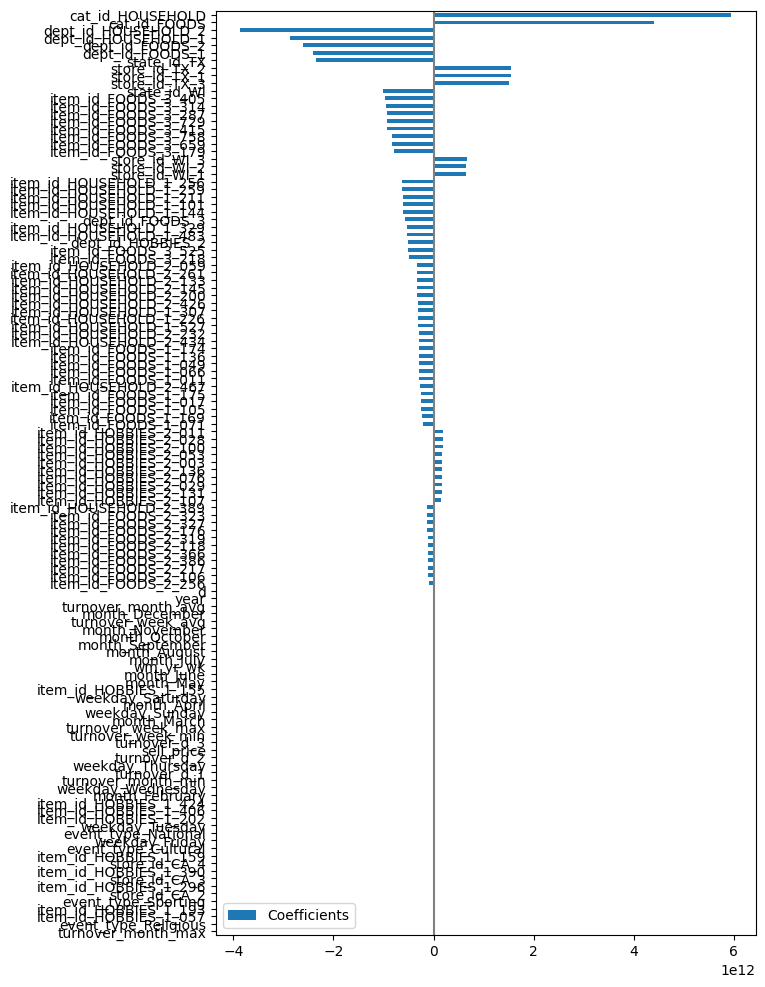

In [111]:
print("Importance of features:")
print("Reference category \n event_type = None \n weekday = Friday \n store_id = CA_1 \n dept_id = FOODS_1 \n")

coefs = pd.DataFrame(lin_reg.coef_, columns=["Coefficients"], index=X_train.columns)
coefs['Absolute_Coefficients'] = coefs['Coefficients'].abs()  
coefs = coefs.sort_values(by="Absolute_Coefficients", ascending=True) 
coefs.drop(columns=["Absolute_Coefficients"], inplace=True)  
coefs.plot(kind="barh", figsize=(9, 12))
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)
plt.show()

In [ ]:
with open('../models/lin_reg_model.pkl', 'wb') as file:
    pickle.dump(lin_reg, file)

### Lasso regression

In [112]:
alpha = 0.01
print(alpha)
lasso = Lasso(alpha=alpha,max_iter=2000)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))

print(lasso_rmse)

0.01
5.333124714458712


In [54]:
coefs_lasso = pd.DataFrame(lasso.coef_, columns=["Coefficients"], index=X_train.columns).sort_values(by = 'Coefficients',ascending=False)
coefs_lasso

,Coefficients
turnover_month_avg,0.693623
weekday_Sunday,0.484265
weekday_Saturday,0.472491
turnover_week_avg,0.324595
turnover_week_min,0.065953
...,...
turnover_d_3,-0.034599
turnover_d_2,-0.035744
turnover_month_min,-0.061419
weekday_Wednesday,-0.086608


In [16]:
len(coefs_lasso) - len(coefs_lasso[coefs_lasso.Coefficients == 0])

165

In [85]:
#Lasso Regression model
sequence = [i /10000.0 for i in range(1, 10)]
RMSE = pd.DataFrame(index=sequence)

for alpha in sequence:
    print(alpha)
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
    RMSE.loc[alpha,'RMSE'] = lasso_rmse
    

0.001



KeyboardInterrupt



In [307]:
RMSE

,RMSE
0.01,4.500777
0.02,4.503627
0.03,4.506558
0.04,NaN
0.05,NaN
0.06,NaN
0.07,NaN
0.08,NaN
0.09,NaN


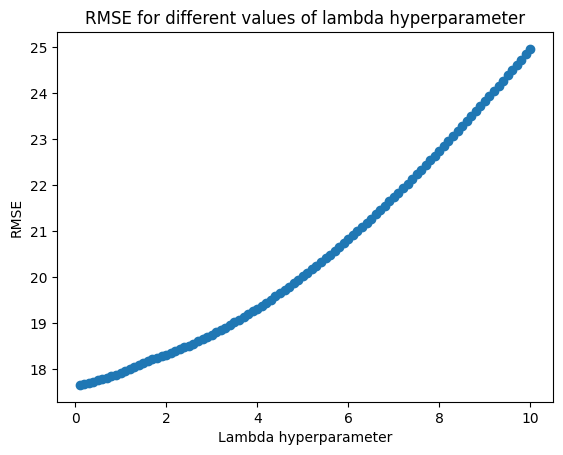

In [16]:
plt.title("RMSE for different values of lambda hyperparameter")
plt.xlabel("Lambda hyperparameter")
plt.ylabel("RMSE")
plt.scatter(sequence, RMSE['RMSE'])

### Random Forest Regression

In [94]:
#Random Forest model
SEED = 88
param_grid = {
    'n_estimators': [50],
    'max_depth': [20,], #25,30
    'min_samples_split': [2,8],
    'min_samples_leaf': [4,6],
    'max_features': [5] #'sqrt', 'log2'
}

best_RMSE = 999
best_params = {}

for n_estimators in param_grid['n_estimators']:
    for max_depth in param_grid['max_depth']:
        for min_samples_split in param_grid['min_samples_split']:
            for min_samples_leaf in param_grid['min_samples_leaf']:
                for max_features in param_grid['max_features']:
                    print(1)
                    # Create and train a Random Forest model with the current hyperparameters
                    rf = RandomForestRegressor(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        max_features=max_features,
                        random_state=SEED                        
                    )
                    print(2)
                    rf.fit(X_train, y_train)
                    print(3)
                    # Evaluate the model on the validation set
                    y_pred_rf = rf.predict(X_test)
                    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_rf))
                    print(4)
                    # Update the best hyperparameters if this combination is better
                    if RMSE < best_RMSE:
                        best_RMSE = RMSE
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf,
                            'max_features': max_features
                        }
                    print(n_estimators, max_depth, min_samples_split, min_samples_leaf, max_features, '=> RMSE: ', RMSE)

1
2
3
4
50 20 2 4 5 => RMSE:  5.561982804278414
1
2
3
4
50 20 2 6 5 => RMSE:  5.5432130654377945
1
2
3
4
50 20 8 4 5 => RMSE:  5.561982804278414
1
2
3
4
50 20 8 6 5 => RMSE:  5.5432130654377945


In [ ]:
print(best_params)

{'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}


In [154]:
#best_params = {'n_estimators': 200, 'max_depth': 20, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}

In [69]:
SEED=88
n_estimators = best_params["n_estimators"]
max_depth = best_params["max_depth"]
min_samples_split = best_params["min_samples_split"]
min_samples_leaf = best_params["min_samples_leaf"]
max_features = best_params["max_features"]

rf = RandomForestRegressor(
    n_estimators=n_estimators,
    max_depth=max_depth,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    max_features=max_features,
    random_state=SEED
)
rf.fit(X_train, y_train)

# Evaluate the model on the validation set
y_pred_rf = rf.predict(X_validation)
RMSE = np.sqrt(mean_squared_error(y_validation, y_pred_rf))

print(RMSE)

KeyError: 'min_samples_split'

In [180]:
pd.DataFrame({'Variable':X_train.columns,
              'Importance':rf.feature_importances_}).sort_values('Importance', ascending=False)[0:10]

,Variable,Importance
1,turnover_month_avg,0.195346
4,turnover_week_avg,0.157446
2,turnover_month_max,0.104984
5,turnover_week_max,0.088007
6,turnover_week_min,0.073108
7,turnover_d_1,0.071616
8,turnover_d_2,0.056837
9,turnover_d_3,0.046527
3,turnover_month_min,0.041268
0,wm_yr_wk,0.028415


In [ ]:
with open('../models/rndm_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)

### XGBoost model

In [115]:
SEED = 88

param_grid = {'learning_rate': [0.01,0.1,0.5], # 0.05,0.1,   alias eta, Step size shrinkage used in update to prevents overfitting.
    'n_estimators': [50,75,100,150,200], # 
    'subsample': [0,1,0.2,0.5,0.3,1], #     Subsample ratio of the training instances
    'max_depth': [1, 3, 5,8,12],
    'reg_lambda':[0.01,0.1,0.2,0.4]
    }

best_RMSE = 999
best_params = {}

for learning_rate in param_grid['learning_rate']:
    for n_estimators in param_grid['n_estimators']:
        for subsample in param_grid['subsample']:
            for max_depth in param_grid['max_depth']:
                for reg_lambda in param_grid['reg_lambda']:
                    # Create and train a Random Forest model with the current hyperparameters
                    xgb = xgboost.XGBRegressor(random_state=SEED, 
                                        objective='reg:squarederror',
                                        learning_rate=learning_rate,
                                        n_estimators=n_estimators,
                                        subsample=subsample,
                                        max_depth=max_depth,
                                        reg_lambda = reg_lambda)
                    
                    xgb.fit(X_train[['turnover_month_avg','turnover_week_avg']], y_train)

                    # Evaluate the model on the validation set
                    y_pred_xgb = xgb.predict(X_test[['turnover_month_avg','turnover_week_avg']])
                    RMSE = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

                    # Update the best hyperparameters if this combination is better
                    if RMSE < best_RMSE:
                        best_RMSE = RMSE
                        best_params = {
                            'learning_rate': learning_rate,
                            'n_estimators': n_estimators,
                            'subsample': subsample,
                            'max_depth': max_depth
                        }
                    print(learning_rate,n_estimators,subsample,max_depth,reg_lambda, '=> RMSE: ', RMSE)

0.01 50 0 1 0.01 => RMSE:  7.073678999783503
0.01 50 0 1 0.1 => RMSE:  7.073678999783503
0.01 50 0 1 0.2 => RMSE:  7.073678999783503
0.01 50 0 1 0.4 => RMSE:  7.073678999783503
0.01 50 0 3 0.01 => RMSE:  7.073678999783503
0.01 50 0 3 0.1 => RMSE:  7.073678999783503
0.01 50 0 3 0.2 => RMSE:  7.073678999783503
0.01 50 0 3 0.4 => RMSE:  7.073678999783503
0.01 50 0 5 0.01 => RMSE:  7.073678999783503
0.01 50 0 5 0.1 => RMSE:  7.073678999783503
0.01 50 0 5 0.2 => RMSE:  7.073678999783503
0.01 50 0 5 0.4 => RMSE:  7.073678999783503
0.01 50 0 8 0.01 => RMSE:  7.073678999783503
0.01 50 0 8 0.1 => RMSE:  7.073678999783503
0.01 50 0 8 0.2 => RMSE:  7.073678999783503
0.01 50 0 8 0.4 => RMSE:  7.073678999783503
0.01 50 0 12 0.01 => RMSE:  7.073678999783503
0.01 50 0 12 0.1 => RMSE:  7.073678999783503
0.01 50 0 12 0.2 => RMSE:  7.073678999783503
0.01 50 0 12 0.4 => RMSE:  7.073678999783503
0.01 50 1 1 0.01 => RMSE:  6.635265162969329
0.01 50 1 1 0.1 => RMSE:  6.635266763203482
0.01 50 1 1 0.2 => RMS

In [116]:
print(best_params, best_RMSE)

{'learning_rate': 0.1, 'n_estimators': 100, 'subsample': 0.3, 'max_depth': 5} 5.496805620618276


In [195]:
with open('../models/xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb, file)

In [25]:
pd.DataFrame({'Variable':X_train.columns,
              'Importance':xgb.feature_importances_}).sort_values('Importance', ascending=False).head(50)

,Variable,Importance
4,turnover_month_avg,0.158901
340,id_HOBBIES_1_155_WI_2_validation,0.060545
798,state_id_TX,0.031296
7,turnover_week_avg,0.030058
332,id_HOBBIES_1_155_CA_1_validation,0.020906
789,store_id_CA_2,0.017096
804,weekday_Tuesday,0.016731
808,month_December,0.016250
802,weekday_Sunday,0.015276
806,month_April,0.015146
